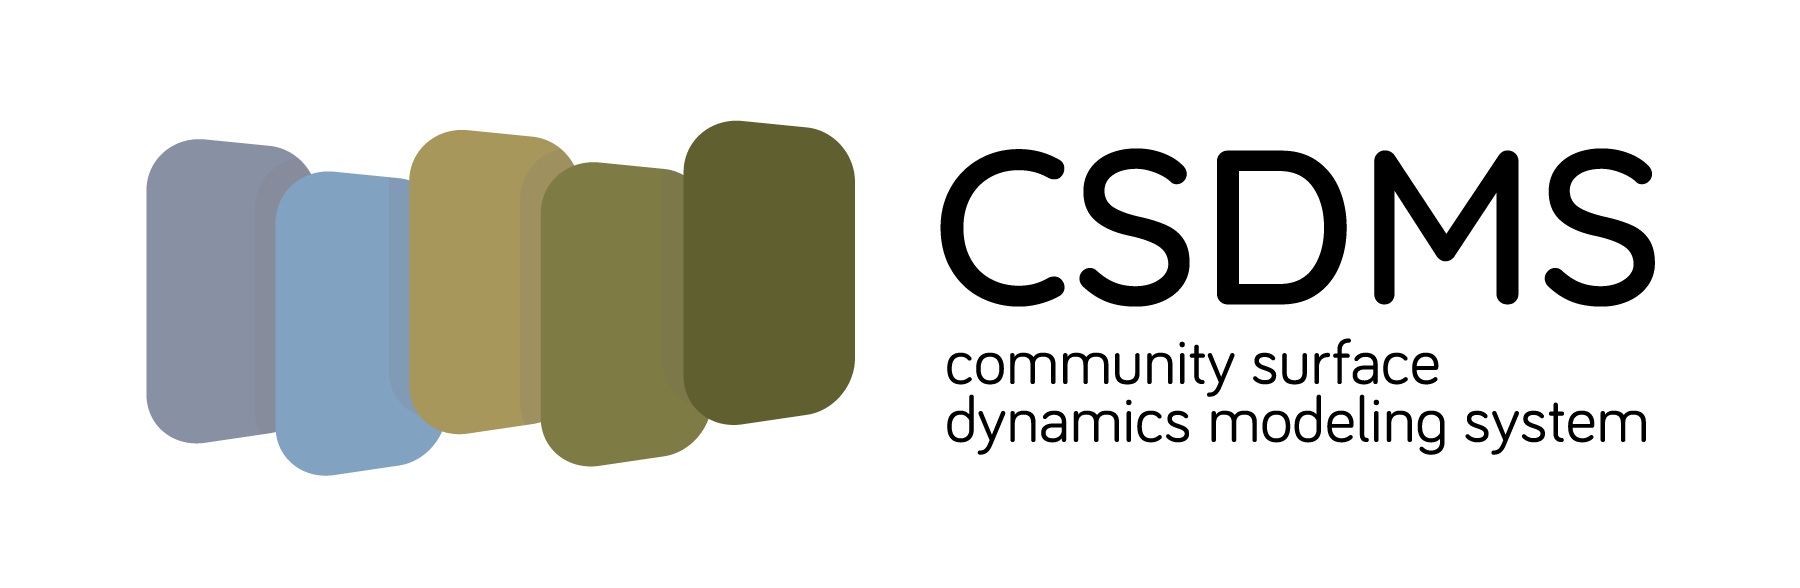

# Glacier Meltwater Runoff Model
This notebook walks through modeling how meltwater will flow over a glacier and how it will change with different kinds of meltwater production and firn presence. This was a Team Project created for CSDMS - Earth Surface Processes Institute (ESPIn) Workshop 2023.

#### Team Members
David Carchipulla-Morales (Wake Forest University)

Jonas Eschenfelder (Simon Fraser University)

Emily Glazer (Columbia University)

Naureen Khan (State University of New York at Buffalo)

Mikayla Pascual (University of Texas at Austin)

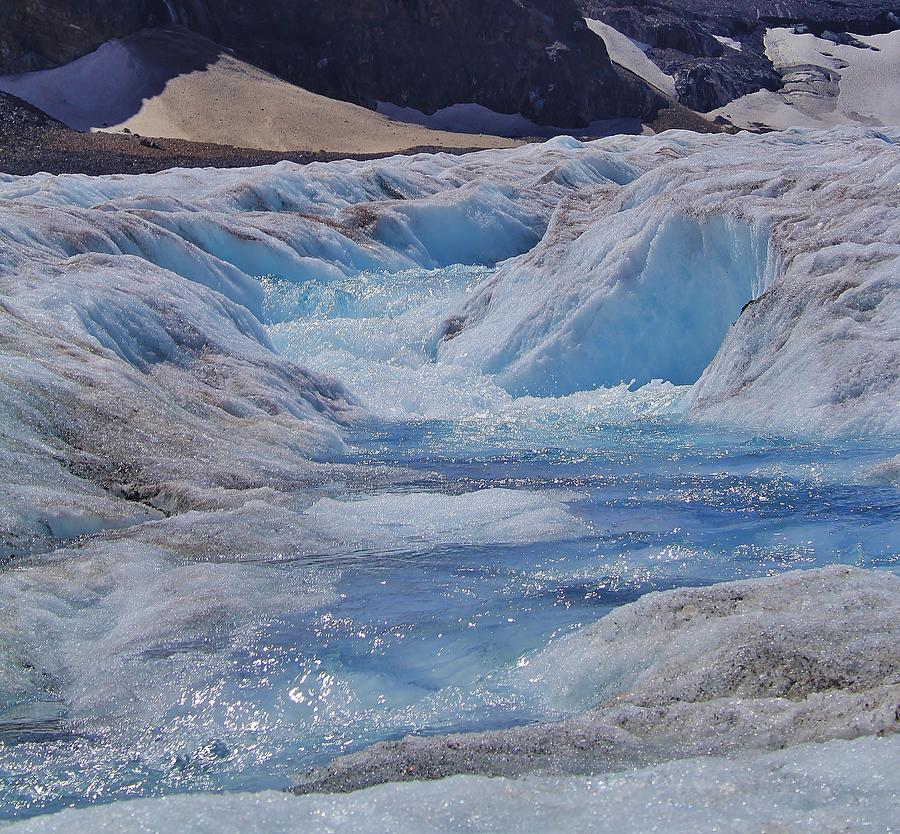

Image: Banff National Park

### Why is surface hydrology important?

- water resources
- understanding glacier system
- climate and stability of future glaciers 

### Study motivation and objectives

Glacier Surface Hydrology is the key role to understand and study the meltwater dynamics of when and how water flows across glaciers and ice sheets. This lab notebook is desgined for undergraduates and graduate students to learn how meltwater flows across different types of glaciers in the world. Users will explore how water will flow on a synthetic glacier with varying surface topography and a mountain glacier through tools from Landlab and other glaciological concepts.

### Imports

In [1]:
from landlab.components import (
    FlowDirectorD8,
    FlowDirectorMFD,
    FlowDirectorSteepest,
    FlowAccumulator, 
    SinkFillerBarnes,
    DepressionFinderAndRouter
)

from bmi_topography import Topography
from landlab import RasterModelGrid
from landlab.plot.drainage_plot import drainage_plot
from landlab.plot.graph import plot_graph
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import scipy.io
from scipy.ndimage import gaussian_filter

from GlacierSurfaceFlow import GlacierSurfaceFlow
from plotting import flowdir_plot

## Running flow accumulator on channel synthetic glacier

Note: We have created three synthetic glacier surfaces: parabola, channel, and nye dome. For this example we show water flow accumulation for a channelized glacier.

#### Instantiating class and plotting surface elevation

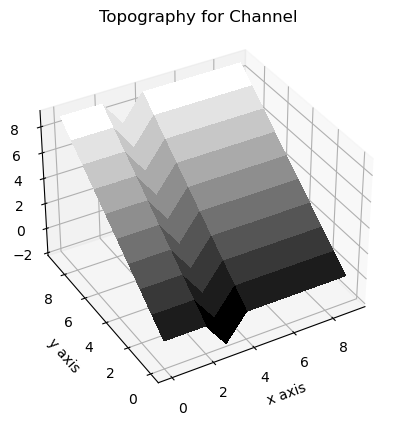

In [2]:
channel = GlacierSurfaceFlow('Channel')
channel.create_flow_acc()
channel.surf_plot()

#### Plotting drainage area without meltwater

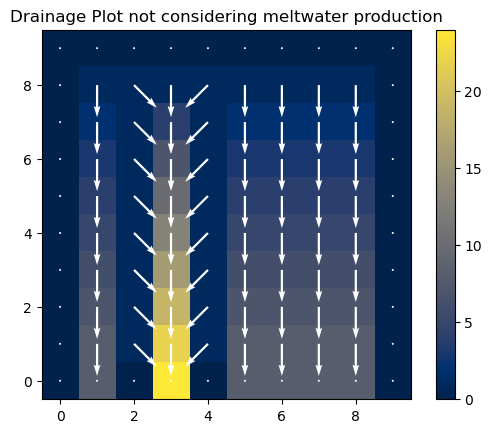

In [3]:
flowdir_plot(channel.grid,1,title='Drainage Plot not considering meltwater production',surface='surface_water__discharge')
plt.show()

#### Incorporating heterogeneous melt production

In [4]:
runoff_rate = np.ones_like(channel.grid.at_node['water__unit_flux_in']) * 10
runoff_rate[(channel.grid.y_of_node==7) & (channel.grid.x_of_node==7)] = 100
channel.grid.at_node['water__unit_flux_in'] = runoff_rate

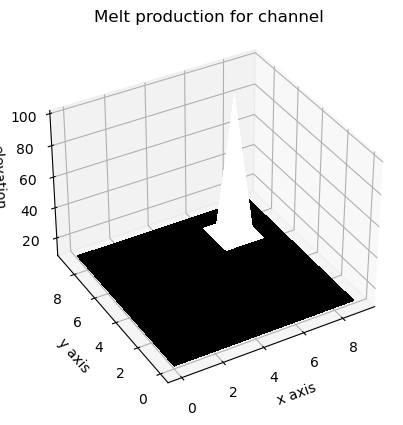

In [5]:
#channel.grid.at_node.keys()
channel.surf_plot(surface='water__unit_flux_in',title='Melt production for channel')

FlowAccumulator found both the field 'water__unit_flux_in' and a provided float or array for the runoff_rate argument. THE FIELD IS BEING OVERWRITTEN WITH THE SUPPLIED RUNOFF_RATE!


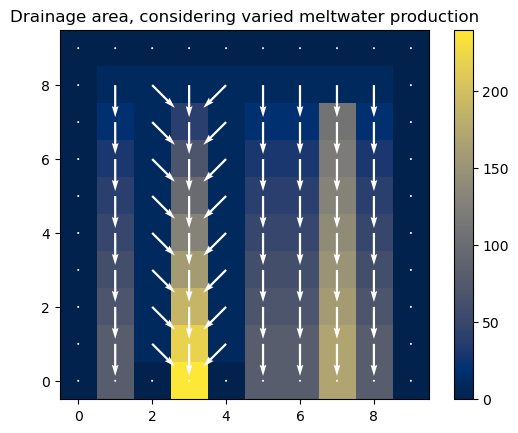

In [6]:
channel.create_flow_acc(runoff_rate = runoff_rate)
flowdir_plot(channel.grid,1,surface='surface_water__discharge',title='Drainage area, considering varied meltwater production')
plt.show()

#### Incorporating firn presence

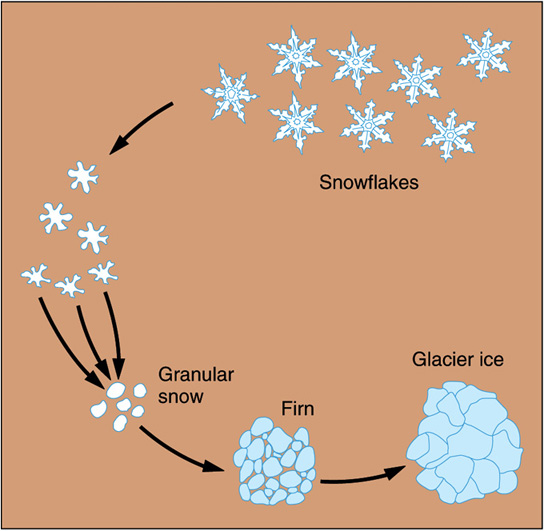

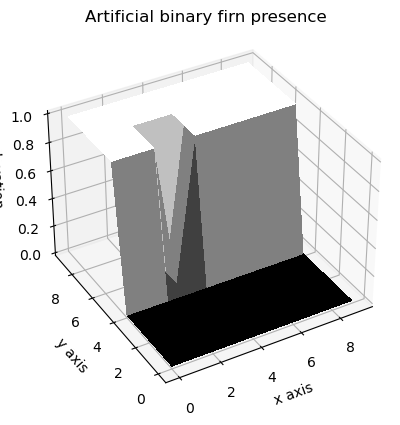

In [7]:
channel.create_binary_firn()
channel.surf_plot('firn__presence', title='Artificial binary firn presence')

In [8]:
def binary_loss_f(Qw,node_ID,linkID,grid):
    A = grid.spacing[0]*grid.spacing[1]
    #const = 0.00981*A
    const = 100*A
    return Qw - const*grid.at_node['firn__presence'][node_ID]

In [9]:
channel.create_loss_flow_acc(binary_loss_f,runoff_rate=runoff_rate)

FlowAccumulator found both the field 'water__unit_flux_in' and a provided float or array for the runoff_rate argument. THE FIELD IS BEING OVERWRITTEN WITH THE SUPPLIED RUNOFF_RATE!


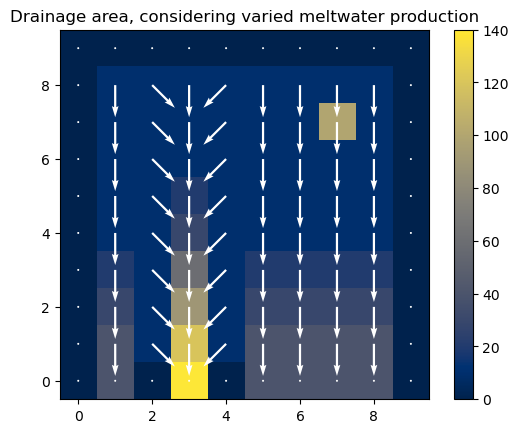

In [10]:
flowdir_plot(channel.grid,1,surface='surface_water__discharge',title='Drainage area, considering varied meltwater production')
plt.show()

## Running flow accumulator on Chimborazo Glacier, Northern Andes DEM

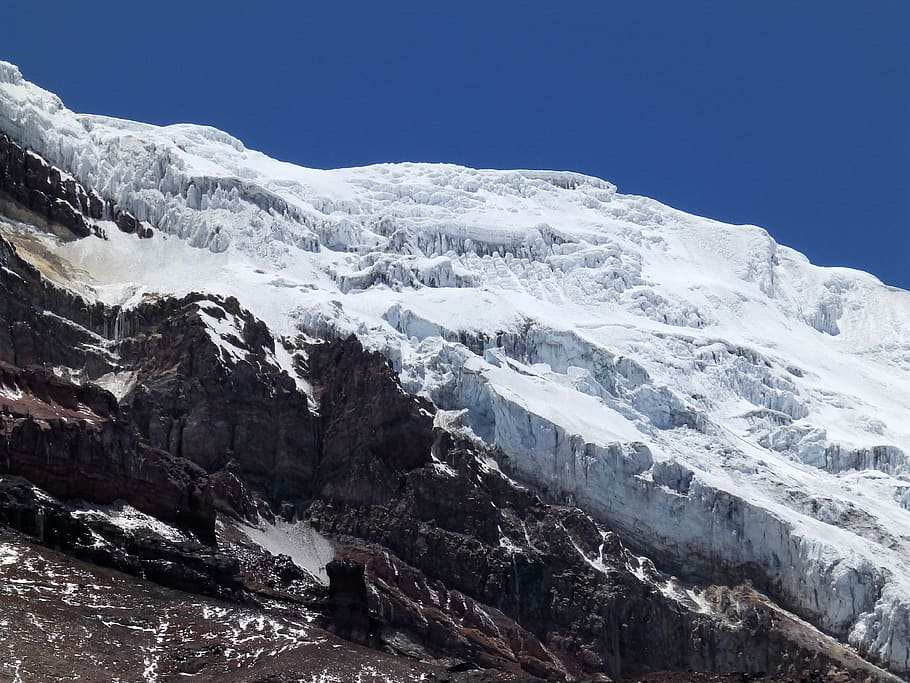

Image: Chimborazo Glacier

#### Instantiating class and plotting surface elevation from BMI topography

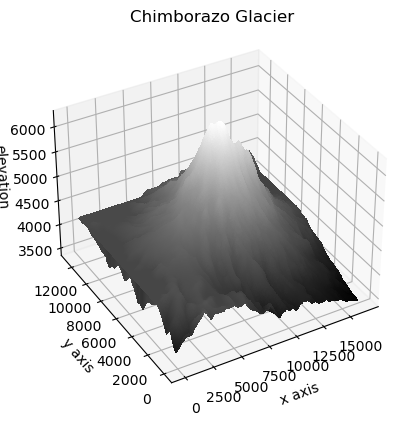

In [11]:
andes = GlacierSurfaceFlow('Andes')
andes.create_flow_acc()
andes.surf_plot(title='Chimborazo Glacier')

#### Visualizing Chimborazo as a 2D DEM

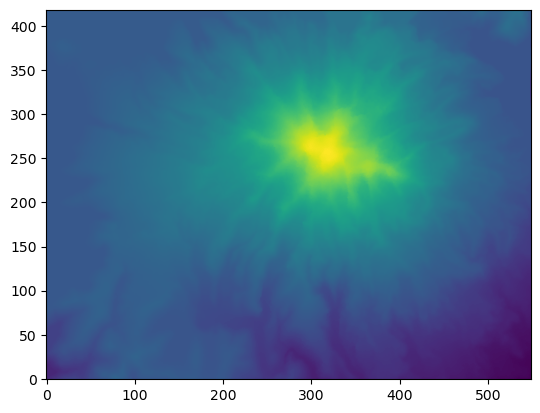

In [12]:
fig,ax=plt.subplots()
ny,nx = andes.grid.number_of_node_rows,andes.grid.number_of_node_columns
ax.imshow(np.reshape(andes.grid.at_node['topographic__elevation'], (ny,nx)),origin='lower')

#### Plotting drainage area

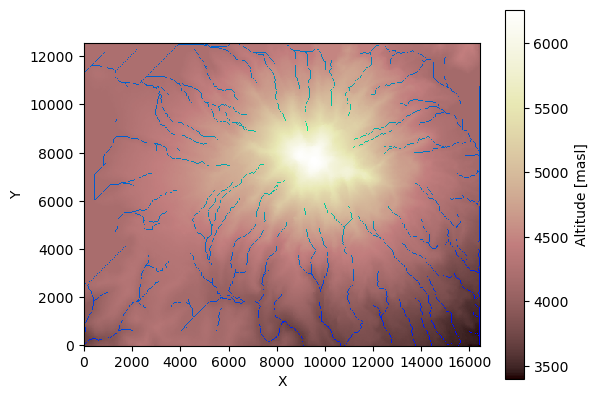

In [13]:
andes.dem_da_plot(da_threshold1 = 0.5e6)

#### Incorporating heterogeneous melt production based on climate data (ERA5)

In [14]:
snowmelt = xr.open_dataset('andes_ERA5_data.nc').smlt.mean(dim=['time'])
runoff_rate = andes.grid.add_ones('water__unit_flux_in',at='node',clobber=True)

runoff_rate[(andes.grid.y_of_node >= andes.grid.y_of_node.max()/2) & (andes.grid.x_of_node >= andes.grid.x_of_node.max()/2)] = snowmelt[1][1]
runoff_rate[(andes.grid.y_of_node >= andes.grid.y_of_node.max()/2) & (andes.grid.x_of_node < andes.grid.x_of_node.max()/2)] = snowmelt[1][0]
runoff_rate[(andes.grid.y_of_node < andes.grid.y_of_node.max()/2) & (andes.grid.x_of_node >= andes.grid.x_of_node.max()/2)] = snowmelt[0][1]
runoff_rate[(andes.grid.y_of_node < andes.grid.y_of_node.max()/2) & (andes.grid.x_of_node < andes.grid.x_of_node.max()/2)] = snowmelt[0][0]

runoff_rate = gaussian_filter(andes.grid.at_node['water__unit_flux_in'].reshape(andes.grid.shape),100)
andes.grid.at_node['water__unit_flux_in'] = runoff_rate.reshape(andes.grid.shape)
#np.flip(runoff_rate,axis=1)

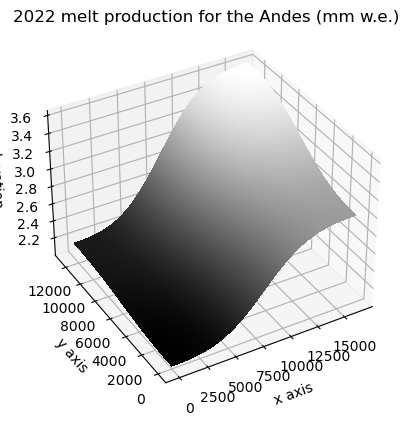

In [15]:
andes.surf_plot(surface='water__unit_flux_in',title = '2022 melt production for the Andes (mm w.e.)')

### Conclusions

- We explore how melt water is routed across glaciers using a synthetic and real case
- We visualize how differential melt production can impact glacial routing.
- It is important to know where meltwater productiton sources are coming from, or localized, since we see in the synthetic glacier case that meltwater flow is occuring in places outside of the channel.
- Firn presence can slow surface water accumulation.
- We provide an initial framework for exploring meltwater and firn processes for glaciers within the Landlab infrastructure. 

### Next Steps

1. Explore how FlowAccumulator can work for ice sheets
2. Incorporate a more robust representation of a firn layer 
3. Add our classes to the Landlab framework

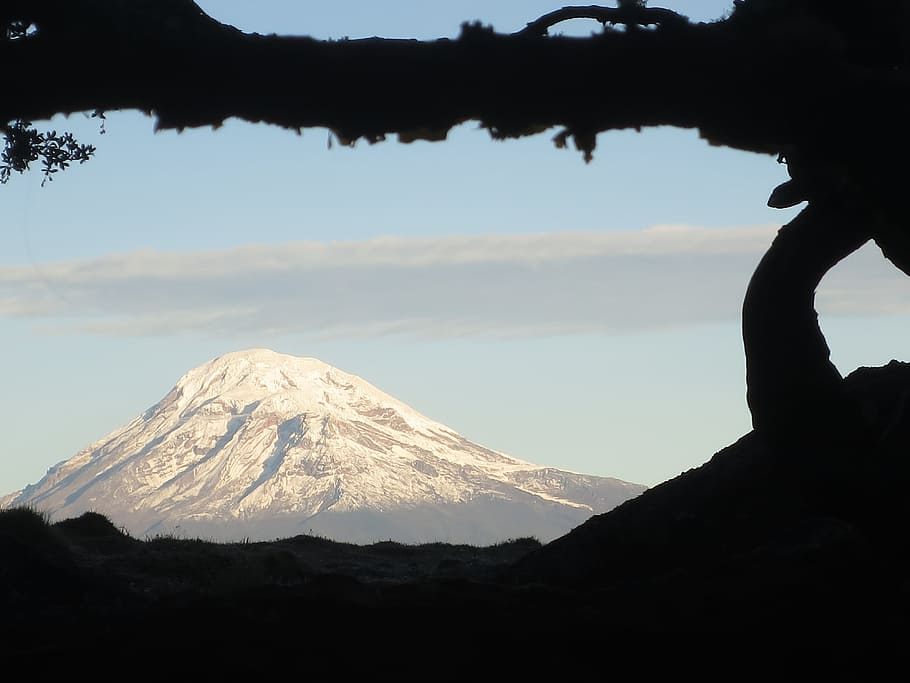

Image: Chimborazo Glacier

### Backup Code

##### Plot synthetic glacier surfaces

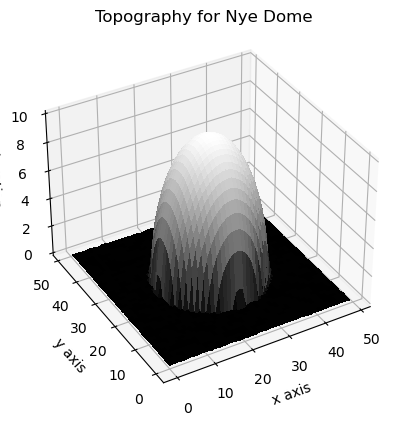

In [17]:
NyeDome = GlacierSurfaceFlow('Nye Dome')
NyeDome.surf_plot()

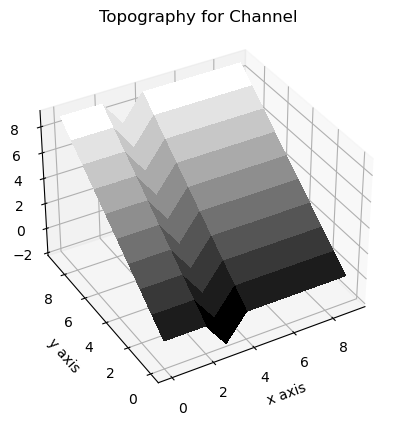

In [18]:
channel = GlacierSurfaceFlow('Channel')
channel.surf_plot()

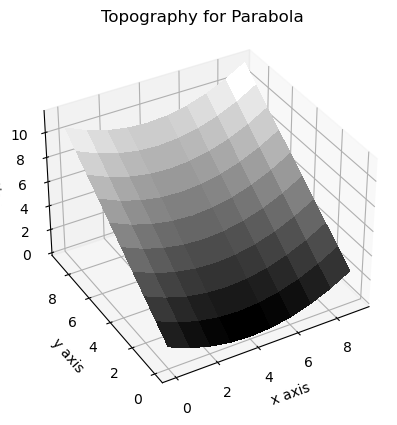

In [19]:
parabola = GlacierSurfaceFlow('Parabola')
parabola.surf_plot()